In [222]:
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bagpy
import seaborn as sns
pd.set_option('display.max_rows', None)

## Парсинг .bag файла

In [223]:
bagfile = bagreader(r'20230125_175832.bag')

[INFO]  Data folder 20230125_175832 already exists. Not creating.


### Читаем сводную таблицу о работе датчиков, о их типах и тд, короче все, что есть

In [224]:
bagfile.topic_table

,Topics,Types,Message Count,Frequency
0,/device_0/info,diagnostic_msgs/KeyValue,13,NaN
1,/device_0/sensor_0/Depth_0/image/data,sensor_msgs/Image,376,14.987974
2,/device_0/sensor_0/Depth_0/image/metadata,diagnostic_msgs/KeyValue,9024,NaN
3,/device_0/sensor_0/Depth_0/info,realsense_msgs/StreamInfo,1,NaN
4,/device_0/sensor_0/Depth_0/info/camera_info,sensor_msgs/CameraInfo,1,NaN
5,/device_0/sensor_0/Depth_0/tf/0,geometry_msgs/Transform,1,NaN
6,/device_0/sensor_0/info,diagnostic_msgs/KeyValue,2,NaN
7,/device_0/sensor_0/option/Asic_Temperature/des...,std_msgs/String,1,NaN
8,/device_0/sensor_0/option/Asic_Temperature/value,std_msgs/Float32,1,NaN
9,/device_0/sensor_0/option/Depth_Units/description,std_msgs/String,1,NaN


### Удаляем нулы из поля Frequency(частота), оставляем только те датчики, которые работали

In [225]:
bag_with_data = bagfile.topic_table.dropna()

In [226]:
bag_with_data

,Topics,Types,Message Count,Frequency
1,/device_0/sensor_0/Depth_0/image/data,sensor_msgs/Image,376,14.987974
50,/device_0/sensor_1/Color_0/image/data,sensor_msgs/Image,377,14.985774
89,/device_0/sensor_2/Accel_0/imu/data,sensor_msgs/Imu,2555,102.137367
94,/device_0/sensor_2/Gyro_0/imu/data,sensor_msgs/Imu,5025,200.185131


sensor_msgs/Image - это сообщение в рамках ROS (Robot Operating System),
которое представляет изображение в виде матрицы пикселей, а также содержит метаданные,
такие как ширина и высота изображения, формат изображения и временную метку.
а теперь переводим в табличныe csv файлs все данные с четырех работавших датчиков
метод message_by_topic - literally "сообщения, которые передал датчик"

In [227]:
Accel_csv_file = bagfile.message_by_topic('/device_0/sensor_2/Accel_0/imu/data')
Depth_csv_file = bagfile.message_by_topic('/device_0/sensor_0/Depth_0/image/data')
Color_csv_file = bagfile.message_by_topic('/device_0/sensor_1/Color_0/image/data')
Gyro_csv_file = bagfile.message_by_topic('/device_0/sensor_2/Gyro_0/imu/data')

### Читаем csv файлы с показателями датчиков, записываем в переменные

In [228]:
Accel_Df = pd.read_csv(Accel_csv_file)
Depth_Df = pd.read_csv(Depth_csv_file)
Color_Df = pd.read_csv(Color_csv_file)
Gyro_Df = pd.read_csv(Gyro_csv_file)

In [229]:
Color_Df

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,height,width,encoding,is_bigendian,step,data
0,0.001167,760,1674658712,357340336,1,480,640,rgb8,0,1920,b'\x8b\x8f\x98\x88\x8d\x96\x87\x8f\x96\x88\x90...
1,0.074163,761,1674658712,424053431,1,480,640,rgb8,0,1920,b'\x8b\x8c\x97\x8c\x8e\x98\x88\x8d\x96\x88\x8d...
2,0.135732,762,1674658712,490766287,1,480,640,rgb8,0,1920,b'\x8a\x8e\x95\x8b\x90\x96\x8a\x8c\x94\x8a\x8c...
3,0.204017,763,1674658712,557479382,1,480,640,rgb8,0,1920,b'\x8c\x8e\x98\x8b\x8c\x97\x8a\x8c\x94\x8b\x8d...
4,0.271325,764,1674658712,624192476,1,480,640,rgb8,0,1920,b'\x8a\x8e\x97\x8b\x8f\x98\x8e\x8c\x96\x8d\x8b...
5,0.336696,765,1674658712,690905094,1,480,640,rgb8,0,1920,b'\x8b\x8c\x97\x8b\x8c\x97\x8a\x8e\x99\x8a\x8e...
6,0.404437,766,1674658712,757618904,1,480,640,rgb8,0,1920,b'\x88\x90\x95\x88\x90\x95\x88\x8e\x92\x87\x8d...
7,0.470737,767,1674658712,824332476,1,480,640,rgb8,0,1920,b'\x8b\x8f\x98\x8b\x8f\x98\x8b\x8c\x97\x8b\x8c...
8,0.536726,768,1674658712,891046047,1,480,640,rgb8,0,1920,b'\x88\x90\x95\x88\x90\x95\x8a\x8f\x93\x88\x8e...
9,0.604125,769,1674658712,957759857,1,480,640,rgb8,0,1920,b'\x89\x90\x9a\x88\x8f\x99\x87\x8e\x9a\x87\x8e...


In [230]:
Depth_Df

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,height,width,encoding,is_bigendian,step,data
0,0.061602,758,1674658712,423932314,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
1,0.128208,759,1674658712,490645409,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
2,0.195051,760,1674658712,557358503,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
3,0.261674,761,1674658712,624071360,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
4,0.328318,762,1674658712,690784216,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
5,0.395028,763,1674658712,757497787,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
6,0.461777,764,1674658712,824211359,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
7,0.528503,765,1674658712,890925407,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
8,0.595187,766,1674658712,957638979,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
9,0.661945,767,1674658713,24352551,1,480,640,mono16,0,1280,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...


## Визуализация данных, полученных акселерометром и гироскопическим датчиком

### Графики на основе показаний акселерометра

#### Линейное ускорение по оси X

<Axes: xlabel='Time', ylabel='linear_acceleration.x'>

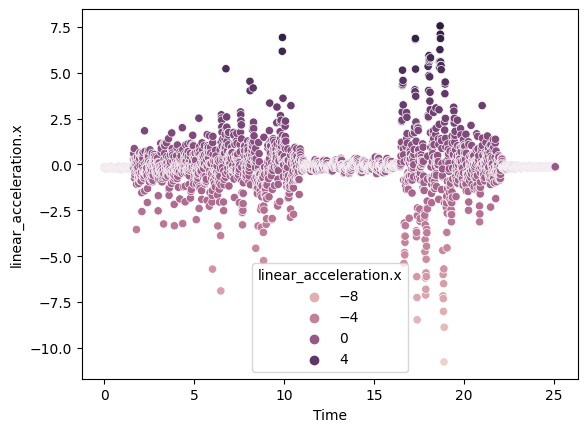

In [231]:
sns.scatterplot(data=Accel_Df, x='Time', y='linear_acceleration.x', hue = 'linear_acceleration.x')

С 17 по 19 секунду Дора резка повернулась сначала вправо, затем влево. Из-за этого, на графики видно резкие изменения.
Остальное время эксперимента собака почти не передвигалась по этой оси, а изменения ускорения происходит от вибрации вентиляторов, расположенных в корпусе собаки.

#### Линейное ускорение по оси Y

<Axes: xlabel='Time', ylabel='linear_acceleration.y'>

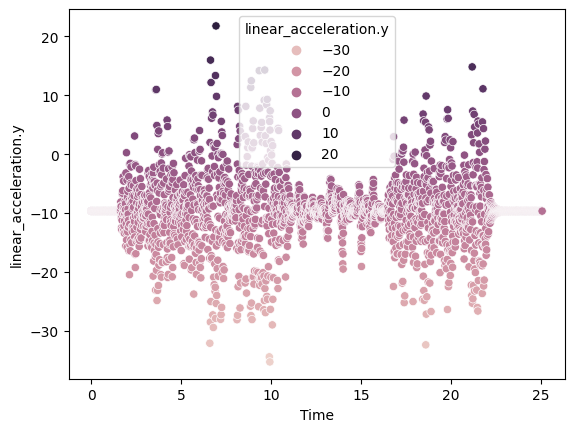

In [232]:
sns.scatterplot(data=Accel_Df, x='Time', y='linear_acceleration.y', hue = 'linear_acceleration.y')

Датчик в процессе в процессе эксперимента не перемещался, на него воздействовали лишь вибрации от 
вентиляторов, расположенных в корпусе робота.

#### Линейное ускорение по оси Z

<Axes: xlabel='Time', ylabel='linear_acceleration.z'>

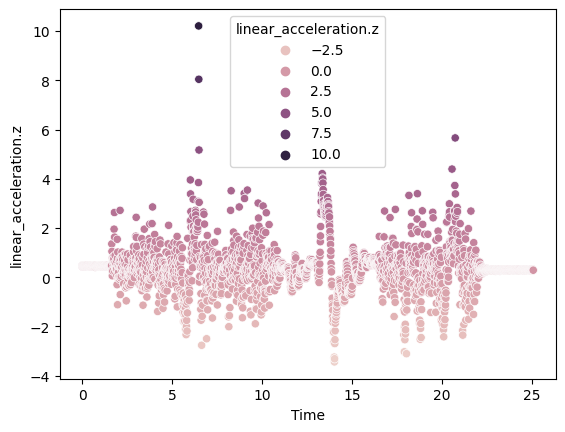

In [233]:
sns.scatterplot(data=Accel_Df, x='Time', y='linear_acceleration.z', hue = 'linear_acceleration.z')

На шестой секунде собака сделал резко шаг назад, из-за этого, ее ускорение увеличилось до 10 единиц, что можно увидеть по графику.
Так же в момент с 13 по 14 секунды произошло резкое изменение ускорение, это произошло из-за то, что собака резко подняла и опустила голову.
Остальное время колебания ускорения происходили из-за вибрации вентиляторов, расположенных в корпусе Доры.


### Графики на основе показаний гироскопического датчика

Мы можем построить графики угловой скорости в зависимости от времени по каждой из трёх осей X, Y, Z

#### Угловая скорость по оси X

<Axes: xlabel='Time', ylabel='angular_velocity.x'>

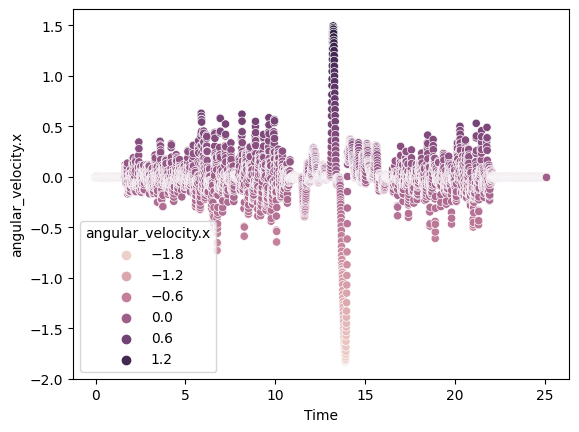

In [234]:
sns.scatterplot(data=Gyro_Df, x='Time', y='angular_velocity.x', hue = 'angular_velocity.x')

Со второй по десятую секунду собака начинает движение, и она трясется вверх - вниз голова. В графике видны незначительные колебания этой величины.
На 11 – 13 секундах, собака сначала немножко опустила голову вниз, вернула ее в исходное положение.
После на 14-15 секунде собака резко подняла голову и так же резко ее опустила. Из - за этого мы видим скачек скорости на этой промежутке времени по оси х.
До 23 секунды собака двигалась, ее голова шаталась и немного менялось угловая скорость по оси Х.

#### Угловая скорость по оси Y

<Axes: xlabel='Time', ylabel='angular_velocity.y'>

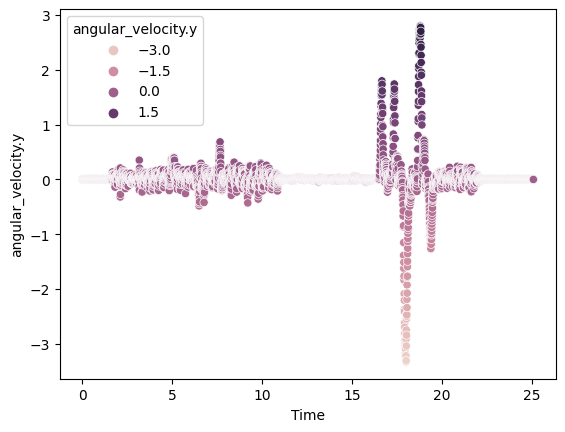

In [235]:
sns.scatterplot(data=Gyro_Df, x='Time', y='angular_velocity.y', hue = 'angular_velocity.y')

До 12 секунды собака двигалась и тряслась, поэтому ее угловая скорость по оси Y колебалась.
До 16 секунды собака, стояла на месте, и лишь двигала головой вверх-вниз. Поэтому угловое ускорение по оси Y никак не менялось.
На секундах 16-20 собака резко начала поворачиваться влево-вправо. На этих секундах графика виден большой скачек угловой скорости по соответствующей оси.

#### Угловая скорость по оси Z

<Axes: xlabel='Time', ylabel='angular_velocity.z'>

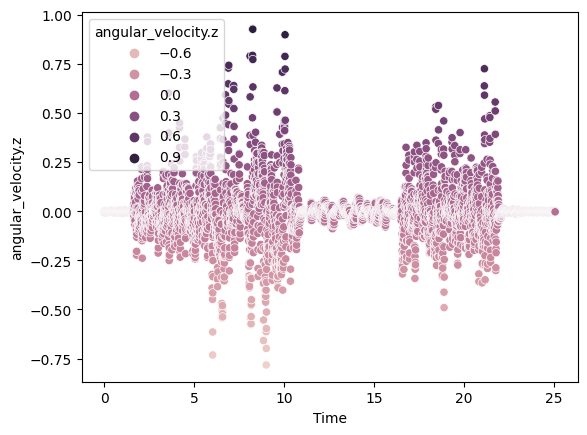

In [236]:
sns.scatterplot(data=Gyro_Df, x='Time', y='angular_velocity.z', hue = 'angular_velocity.z')

Здесь нет никаких резких скачков, потому что собака ни разу не наклоняла на бок свою голову. Поэтому, во все моменты времени, когда она просто перемещалась, мы видим колебания этого графика, т.к. при ходьбе собака трясется. Когда собака поднимала в голову, она почти не наклоняла голову (камера почти не тряслась в это время), поэтому ее угловая скорости по оси Z в это время минимальна.

## Видео

In [237]:
#делаем фотокарточку из Color_Df
#размеры
Height = 480
Width = 640

### Получаем картинку из 1 кадра

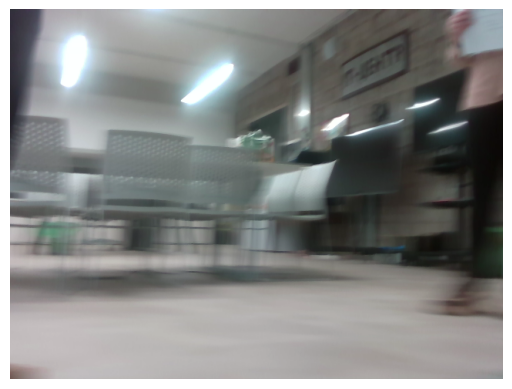

In [238]:
# получить интересующее нас изображение из Pandas DataFrame    
raw_string = Color_Df['data'][260]
# преобразовать в байтовую строку с включенными escape-символами
byte_string = raw_string[2:-1].encode('latin1')
# удалить эскейп символы
escaped_string = byte_string.decode('unicode_escape')
# преобразовать обратно в байтовую строку без экранированных символов
byte_string = escaped_string.encode('latin1')
#создание массива NumPy из байтовой строки
nparr = np.frombuffer(byte_string, np.uint8)
# преобразовать в 3 мерный массив изображений RGB (высота x ширина x 3(R and G and B))
rgb = nparr.reshape((Height, Width, -1))
# рисуем фотографию
plt.axis('off')
plt.imshow(rgb)

### Получаем видео

Мы делаем через opencv

#### RGB

In [239]:
# Функция преобразрвания одного кадра в изображение для rgb
def to_image_rgb(data):
    raw_string = data
    # преобразовать в байтовую строку с включенными escape-символами
    byte_string = raw_string[2:-1].encode('latin1')
    # удалить эскейп символы
    escaped_string = byte_string.decode('unicode_escape')
    # преобразовать обратно в байтовую строку без экранированных символов
    byte_string = escaped_string.encode('latin1')
    #создание массива NumPy из байтовой строки
    nparr = np.frombuffer(byte_string, np.uint8)
    # преобразовать в 3 мерный массив изображений RGB (высота x ширина x 3(R and G and B))
    rgb = nparr.reshape((Height, Width, -1))
    return rgb 

format_video_color = cv2.VideoWriter_fourcc(*'mp4v') # формат видео
video_from_color = cv2.VideoWriter('rgb.mp4', format_video_color, 15.0, (640, 480))

# Функция получения видео rgb
def to_animation_rgb(rgb):
    video_from_color.write(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))

###### Проверим на первом кадре

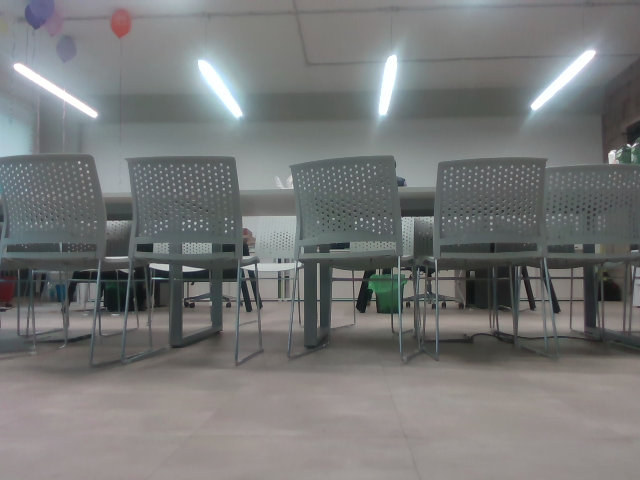

In [240]:
PIL.Image.fromarray(to_image_rgb(Color_Df['data'][0]))

###### Применим ко всему столбцу data

In [241]:
Color_Df['image'] = Color_Df['data'].apply(to_image_rgb)

###### Получим видео

In [242]:
Color_Df['image'].apply(to_animation_rgb)
video_from_color.release()

<video controls src="rgb.mp4" />

#### DEPTH

In [243]:

# Функция преобразрвания одного кадра в изображение для depth
def to_image_depth(data):
    raw_string = data
    # преобразовать в байтовую строку с включенными escape-символами
    byte_string = raw_string[2:-1].encode('latin1')
    # удалить эскейп символы
    escaped_string = byte_string.decode('unicode_escape')
    # преобразовать обратно в байтовую строку без экранированных символов
    byte_string = escaped_string.encode('latin1')
    #создание массива NumPy из байтовой строки
    nparr = np.frombuffer(byte_string, np.uint16)
    # преобразовать в 3 мерный массив изображений RGB (высота x ширина x 3(R and G and B))
    rgb = nparr.reshape((Height, Width, -1))
    rgb = (cv2.convertScaleAbs(rgb / 256)).astype(np.uint8)
    rgb = cv2.cvtColor(cv2.applyColorMap(rgb, cv2.COLORMAP_VIRIDIS), cv2.COLOR_BGR2RGB)
    return rgb


format_video_depth = cv2.VideoWriter_fourcc(*'mp4v') # формат видео
video_from_depth = cv2.VideoWriter('depth.mp4', format_video_depth, 15.0, (640, 480))

# Функция получения видео depth
def to_animation_depth(depth):
    video_from_depth.write(cv2.cvtColor(depth, cv2.COLOR_RGB2BGR))


##### Попробуем на первом кадре

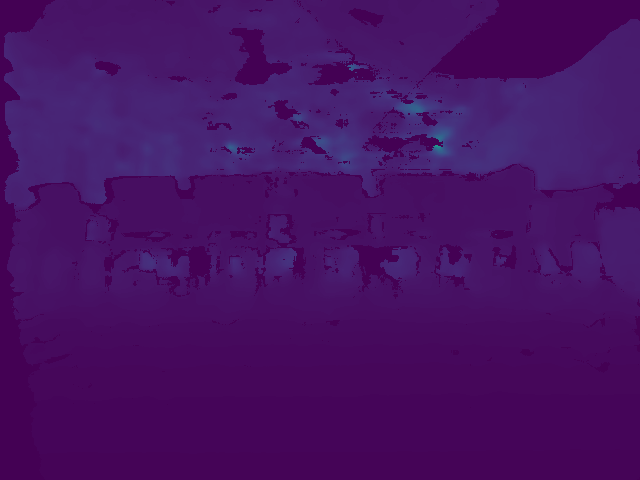

In [244]:
PIL.Image.fromarray(to_image_depth(Depth_Df['data'][0]))

###### Применим ко всему столбцу data

In [245]:
Depth_Df['image'] = Depth_Df['data'].apply(to_image_depth)

###### Получим видео

In [246]:
Depth_Df['image'].apply(to_animation_depth)
video_from_depth.release()

<video controls src="depth.mp4" />